# STAGE 0 : PREPARATION

PROBLEM STATEMENT : **Jumlah nasabah bank yang telah mendaftar deposito berjangka pada Perusahaan Bank ABC masih rendah. Dari 45.211 nasabah, hanya sekitar 11,7 % nasabah saja yang mendaftar deposito berjangka.**

GOAL : **Meningkatkan Conversion Rate User nasabah bank yang mendaftar deposito berjangka minimal sebesar 5% atau dapat dikatakan 1 dari 20 nasabah bank mendaftar deposito berjangka.**

OBJECTIVE : **Melakukan klasifikasi pada customer bank tersebut, sehingga nasabah yang sekiranya tertarik untuk membuka deposito berjangka dapat diprioritaskan terlebih dahulu untuk dihubungi/ditawari deposito berjangka.**

BUSINESS METRICS : **Conversion Rate User yang membuka depostio berjangka**

# STAGE 1 : EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 8)
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'medium'
rcParams['ytick.labelsize'] = 'medium'

In [3]:
df = pd.read_csv('train.csv',sep=';')

## EDA Insight:

### Descriptive Statistics

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Kita dapat melihat bahwa:
* Dataframe memiliki total 45211 baris dan 17 kolom
* Setiap kolom sudah memiliki tipe data yang sesuai
* Dataframe sudah tidak memiliki null value pada setiap kolomnya
* Target klasifikasi adalah kolom `y` dengan tipe data `object`
* Sisanya adalah *feature* (predictor)

In [5]:
nums = ['age','balance','day','duration','campaign','pdays','previous']
cats = ['job','marital','education','default','housing','loan','contact','month','poutcome','y']

### Memeriksa apakah terdapat data duplikat

In [6]:
df.duplicated().any()

False

### **Sampling data using `df.sample()`**

In [7]:
df.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
13690,27,unemployed,single,primary,no,9,no,yes,cellular,9,jul,919,2,-1,0,unknown,yes
27933,29,unknown,single,secondary,no,1502,no,no,cellular,28,jan,59,1,-1,0,unknown,no
8200,36,entrepreneur,married,tertiary,no,0,no,no,unknown,2,jun,87,3,-1,0,unknown,no
27177,31,management,married,tertiary,no,4148,yes,no,cellular,21,nov,316,3,99,9,other,yes
8077,37,unemployed,single,secondary,no,756,yes,no,unknown,2,jun,74,1,-1,0,unknown,no


### **Statistical Summary using `df.describe()`**

In [8]:
df[nums].describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Beberapa pengamatan dari *statistical summary* kolom numerik di atas:
* Jika hanya melihat dari kedekatan nilai mean dan median serta posisi Q2 maka distribusi nilai di kolom `age`,`day`,`campaign` terlihat normal/simetrik (*mean* dan *median* cukup dekat, serta nilai Q2 kurang lebih berada di tengah2 Q1 - Q3).
* Sedangkan kolom `balance`,`duration`, tampaknya tidak simetrik, karena mean > median.
* Pada kolom `balance` terlihat bahwa nilai minimum memiliki angka negatif, yang dirasa wajar jika rekening customer tersebut merupakan rekening giro yang sedang menggunakan fasilitas kredit dari bank tersebut
* Pada kolom `pdays` nilai min, 25%, 50%, dan 75% berisikan -1, angka tersebut merupakan suatu indikator bahwa 'client was not previously contacted in previous campaign'.

Untuk membuktikan argumentasi mengenai bentuk distribusi setiap kolom berdasarkan *statistical summary* diatas akan dilakukan pengecekkan skewness score untuk kolom-kolom numerik tersebut:

In [9]:
import scipy.stats
print('-'*14,'Skewness Score','-'*14)
for i in range(len(nums)):
    skewness_score = scipy.stats.skew(df[nums[i]])
    if skewness_score <= 0.5 and skewness_score>=-0.5:
        print(f'Skewness Score {nums[i]} : {scipy.stats.skew(df[nums[i]])}\n(Normal Distribution)')
    elif skewness_score >0.5:
        print(f'Skewness Score {nums[i]} : {scipy.stats.skew(df[nums[i]])}\n(Right Skewness)')
    else:
        print(f'Skewness Score {nums[i]} : {scipy.stats.skew(df[nums[i]])}\n(Left Skewness)')

-------------- Skewness Score --------------
Skewness Score age : 0.6847952047866451
(Right Skewness)
Skewness Score balance : 8.360030947252687
(Right Skewness)
Skewness Score day : 0.09307592583897241
(Normal Distribution)
Skewness Score duration : 3.1442137770103913
(Right Skewness)
Skewness Score campaign : 4.898487638410557
(Right Skewness)
Skewness Score pdays : 2.615628689259389
(Right Skewness)
Skewness Score previous : 41.84506608797322
(Right Skewness)


* Berarti untuk sementara bentuk persebaran data dapat dilihat bahwa ternyata hanya kolom `age` dan `day` yang berdistribusi normal/simetrik selebihnya mengalami positif skewness. Namun untuk lebih pastinya lagi akan dilakukan dengan pengecekkan secara visualisasi bentuk distribusi setiap kolom saat melakukan Univariate Analysis

In [10]:
df[cats].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


Beberapa pengamatan dari *statistical summary* kolom kategorikal di atas:
* Kolom `job` dan `month`  memiliki jumlah nilai unique yang sangat banyak yaitu mencapai 12 nilai unique. Ada kemungkinan feature ini tidak akan terlalu berguna sebagai predictor.
* Mayoritas data customer memilih "no" untuk membuka deposito (dengan frekuensi 39922 dari 45211 data yang ada). Dimana artinya data customer yang memilih untuk membuka deposito hanya sekitar 11,7% dari total data. Hal ini tentunya menjadi suatu permasalahan dikarenakan dapat membuat model menjadi overfit. Harus dilakukan oversampling.

### Univariate Analysis

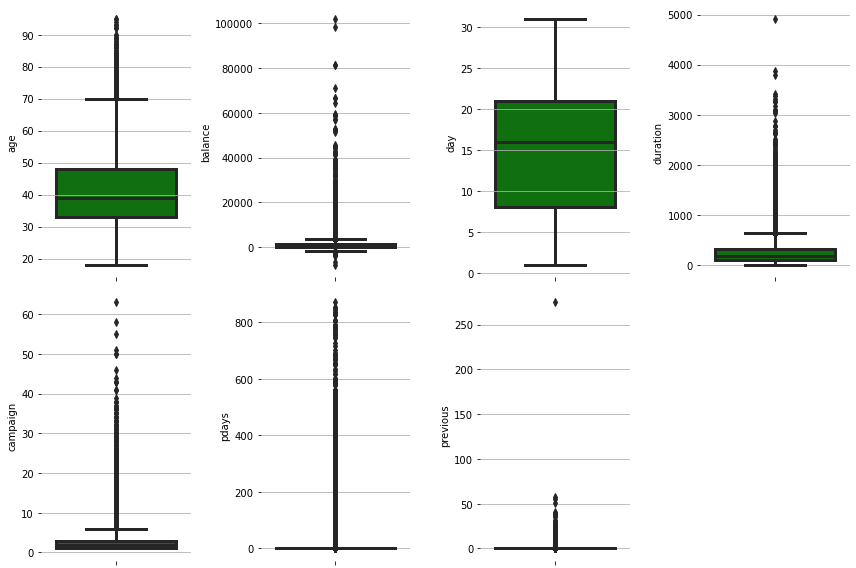

In [11]:
for i in range(len(nums)):
    plt.subplot(2,4,i+1)
    sns.boxplot(y=df[nums[i]],color='g',orient='v')
    plt.grid(axis='y')
    sns.despine(top=True, right=True, left=True, bottom=True)
    plt.tight_layout()

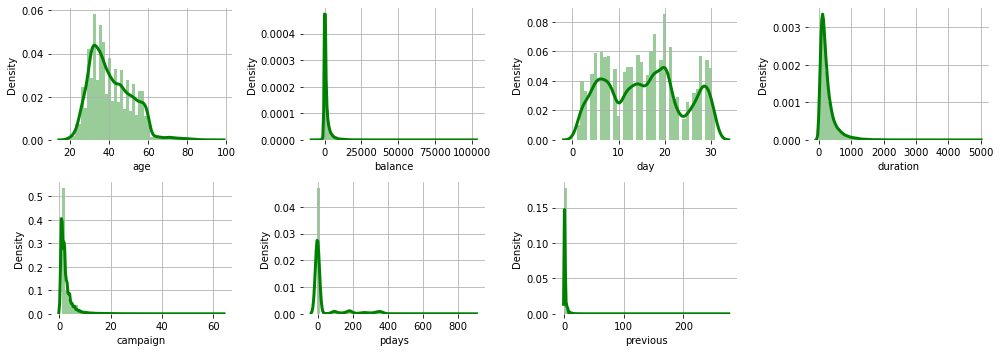

In [12]:
plt.figure(figsize=(14, 5))
for i in range(len(nums)):
    plt.subplot(2,4,i+1)
    sns.distplot(df[nums[i]],color='g')
    plt.grid()
    sns.despine(top=True, right=True, left=True, bottom=True)
    plt.tight_layout()

    Mengenai bentuk distribusi dapat dipastikan bahwa:
* Untuk kolom `balance`, `duration`, `campaign`, `pdays` dan `previous` memiliki distribusi yang terlihat *skewed positif*
* Kolom `day` memiliki distribusi *multimodal*
* Kolom `age` memiliki distribusi yang hampir mendekati normal/simetrik


    Selain itu dapat dilihat juga bahwa:
* Distribusi kolom `age` terkonsentrasi pada umur dibawah 40 tahun
* Dari boxplot dapat dilihat bahwa outlier terlihat utamanya pada kolom `age`, `balance`, `duration`, `campaign`, `pdays` dan `previous`, Pada tahap preprocessing nanti akan dilakukan pengambilan keputusan dalam menghadapi outlier-outlier tersebut.

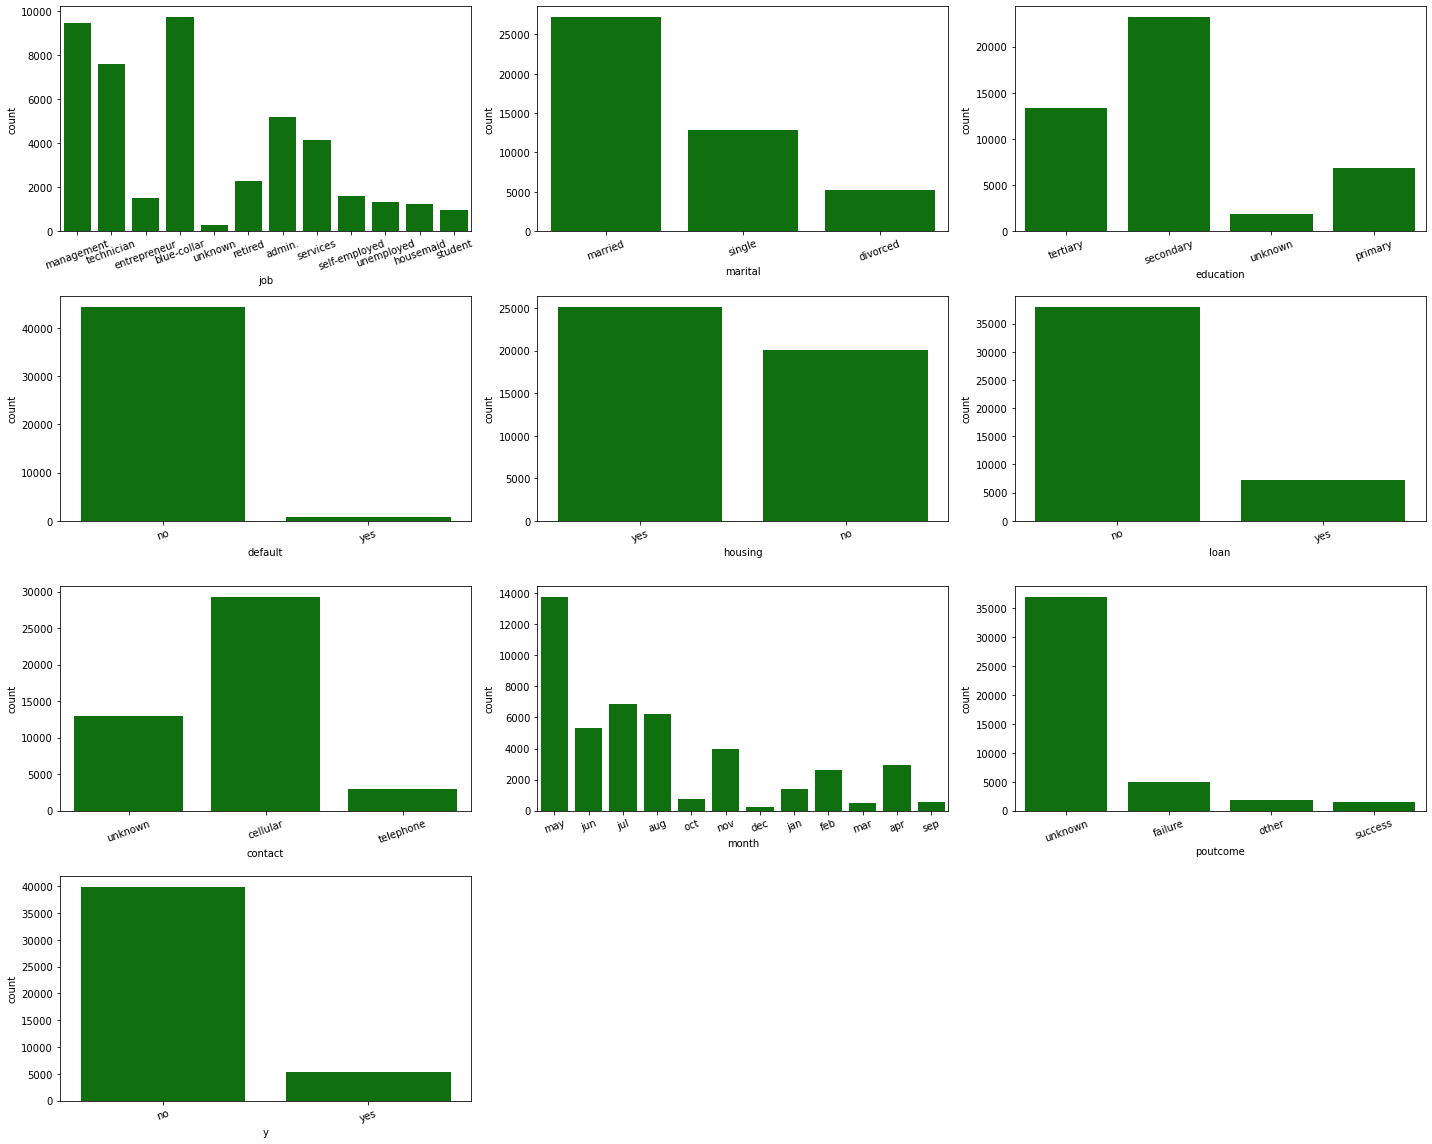

In [13]:
plt.figure(figsize=(20, 16))
for i in range(len(cats)):
    plt.subplot(4, 3, i+1)
    sns.countplot(df[cats[i]], color='g', orient='v')
    plt.xticks(rotation=20)
    plt.tight_layout()

* Untuk feature `job` meskipun memiliki nilai unique yang banyak dapat dilihat bahwa didominasi hanya oleh 5 jenis pekerjaan yaitu "blue-collar", "management", "technician", "admin", dan "services". Pada saat tahap preprocessing selain dari 5 jenis pekerjaan tersebut dapat dijadikan satu kelompok menjadi jenis "others".
* Seperti pengamatan kita sebelumnya, distribusi kolom target yaitu kolom `y` memiliki 2 value yaitu "yes" dan "no". Namun frekuensi antara value "yes" dan "no" tidak seimbang, dimana value "yes" hanya berkisar 11,7% dari keseluruhan value. Oleh sebab itu nanti harus dilakukan **Oversampling**.
* Untuk kolom `education`,`contact` yang memiliki nilai unknown, jika dirasa perlu pada saat preprocessing bisa digantikan dengan nilai mode nya
* Saat proses preprocessing kolom2 kategorikal ini akan dilakukan encoding.

### Multivariate Analysis

In [14]:
df_month_vis = df.copy()
df_month_vis = pd.pivot_table(df_month_vis,
                              index=['month'],
                              columns=['y'],
                              aggfunc={'y':'count'})
df_month_vis.columns =['no','yes']
df_month_vis.drop(['no'],axis=1,inplace=True)
df_month_vis.reset_index(inplace=True)
df_month_vis['total_yes'] = df_month_vis['yes'].sum()
df_month_vis['ratio yes (%)'] = round((df_month_vis['yes']/(df_month_vis['total_yes'])) , 2)

In [15]:
df_month_vis

,month,yes,total_yes,ratio yes (%)
0,apr,577,5289,0.11
1,aug,688,5289,0.13
2,dec,100,5289,0.02
3,feb,441,5289,0.08
4,jan,142,5289,0.03
5,jul,627,5289,0.12
6,jun,546,5289,0.10
7,mar,248,5289,0.05
8,may,925,5289,0.17
9,nov,403,5289,0.08


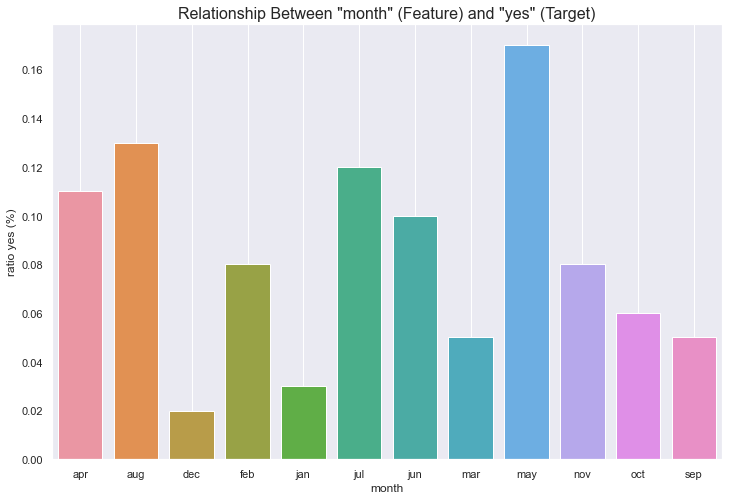

In [16]:
sns.set_theme(style='darkgrid')
sns.barplot(data=df_month_vis , x='month', y='ratio yes (%)')
plt.title('Relationship Between "month" (Feature) and "yes" (Target)',fontsize=16)
plt.grid()
plt.show()

* Dapat dilihat bahwa pada bulan may persentase customer yang melakukan pendaftaran deposito sedikit lebih tinggi dibandingkan bulan-bulan lainnya. Namun jika kita melihat secara keseluruhan pada setiap bulannya jumlah customer yang mendaftar tidaklah berbeda jauh antara satu bulan ke bulan lainnya, bahkan semua bulan tidak ada yg memiliki persentase "yes" lebih besar dari 0,2%. **Hal ini dapat menjadi landasan jika kita memutuskan untuk tidak menggunakan feature `month` terhadap model yang akan kita dibuat, dikarenakan feature `month` tidak memiliki pengaruh yang signifikan perihal seorang customer tertarik mendaftar deposito berjangka**.

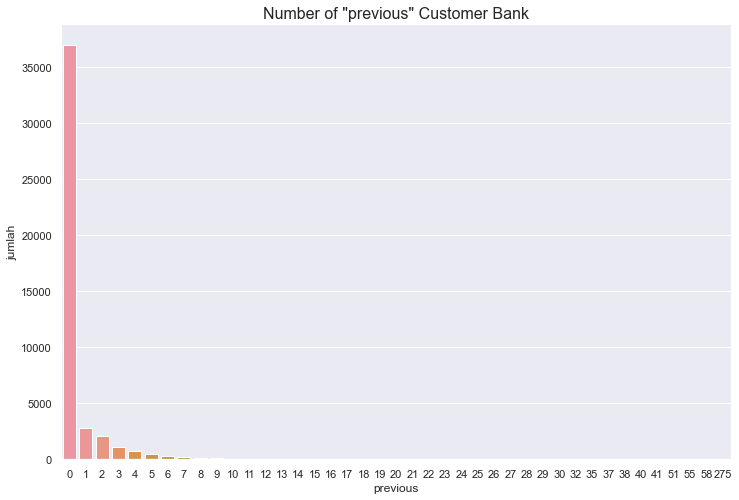

In [17]:
sns.set_theme(style='darkgrid')
previous_chart = df.groupby('previous').agg({'y':'count'}).reset_index()
previous_chart.columns = ['previous','jumlah']
sns.barplot(data=previous_chart , x='previous', y='jumlah')
plt.title('Number of "previous" Customer Bank',fontsize=16)
plt.show()

* Dapat dilihat bahwa sebanyak lebih dari 35000 nasabah (tepatnya 36954) memiliki previous 0, dimana hal tersebut berarti nasabah belum pernah dihubungi pada campaign sebelumnya. Artinya sekitar 81% nasabah belum pernah dihubungi pada campaign sebelumnya. Dengan hal ini menunjukkan bahwa fitur `previous` tidak berpengaruh terhadap outcome y dikarenakan mayoritas dari customer memang belum pernah dihubungi pada campaign sebelumnya. **Oleh sebab itu hal ini dapat dijadikan sebagai landasan kita apabila ingin memutuskan untuk tidak menggunakan feature `previous` terhadap model yang akan kita dibuat**.

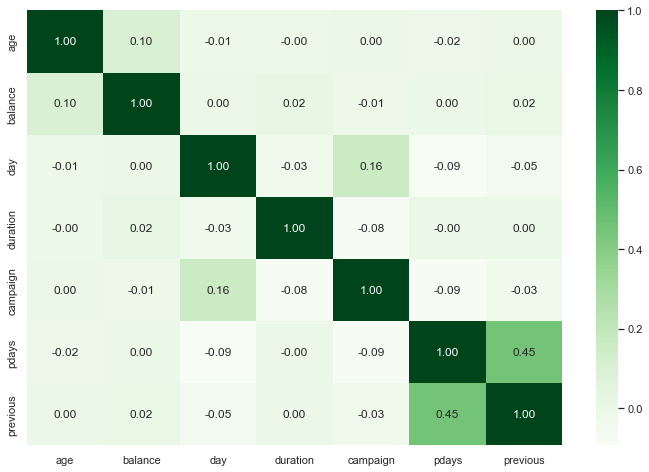

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='Greens', annot=True, fmt='.2f')
plt.show()

* Tidak ada features numerical yang berkorelasi kuat dan dapat dilihat juga bahwa pada features numerical tidak ada yang redundan
* Nantinya setelah melakukan encoding pada tahap preprocessing akan juga dilakukan multivariate analysis untuk mengetahui korelasi antara semua features (baik yang kategorikal maupun numerik) terhadap kolom target yaitu kolom `y`

# STAGE 2 : DATA PREPROCESSING

* month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec") <br>
* day: last contact day of the month (numeric) <br>
* previous: number of contacts performed before this campaign and for this client (numeric) <br>
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

Seperti yang disampaikan pada saat EDA ada beberapa features yang diputuskan untuk tidak digunakan seperti `month`, `previous`. Selain itu ada feature lain yang diputuskan untuk tidak digunakan yaitu `day`,dan `pdays` dikarenakan kedua fitur tersebut secara tidak langsung berhubungan dengan feature yang ingin dibuang yaitu `month` dan `previous`

In [19]:
df = df.drop(['month','previous','day','pdays'],axis=1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  poutcome   45211 non-null  object
 12  y          45211 non-null  object
dtypes: int64(4), object(9)
memory usage: 4.5+ MB


**HANDLING OUTLIER** <br>
Untuk sementara diputuskan untuk tidak menghapus semua data outlier, dikarenakan data outlier tersebut dirasa memiliki nilai yang penting dalam pemodelan machine learning yang akan dilakukan. Jika nantinya performa machine learning dari berbagai algoritma yang dibuat masih belum memuaskan maka akan dicoba untuk menghapus outlier-outlier tersebut.

**HANDLING `job` UNIQUE VALUES**

In [21]:
df.loc[((df['job']=='entrepreneur') | (df['job'] == 'unknown') |
        (df['job']=='retired') | (df['job']=='self-employed') | (df['job']=='unemployed') |
        (df['job']=='housemaid') | (df['job']=='student')) ,'job'] = 'others'

In [22]:
df['job'].value_counts()

blue-collar    9732
management     9458
others         9099
technician     7597
admin.         5171
services       4154
Name: job, dtype: int64

**HANDLING `education` UNKNOWN VALUES**

In [23]:
df['education'].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [24]:
df.loc[(df['education']=='unknown') ,'education'] = 'secondary'

In [25]:
df['education'].value_counts()

secondary    25059
tertiary     13301
primary       6851
Name: education, dtype: int64

**ENCODING**

Label Encoding = default, housing, loan, y, education, contact <br>
One Hot Encoding = job, marital, poutcome

In [26]:
#Label Encoding:

#default
df['default'] = df['default'].apply(lambda x : 0 if x =='no' else 1 )

#housing
df['housing'] = df['housing'].apply(lambda x : 0 if x =='no' else 1 )

#loan
df['loan'] = df['loan'].apply(lambda x : 0 if x =='no' else 1 )

#y
df['y'] = df['y'].apply(lambda x : 0 if x =='no' else 1 )

#education
df['education'] = df['education'].apply(lambda x : 0 if x =='primary' else 1 if x=='secondary'
                                        else 2)

#contact
df['contact'] = df['contact'].apply(lambda x: 0 if x=='cellular' else 1 if x=='telephone' else 2)

In [27]:
#One Hot Encoding:
ohe_job = pd.get_dummies(df['job'], prefix='job')
ohe_marital = pd.get_dummies(df['marital'], prefix='marital')
ohe_poutcome = pd.get_dummies(df['poutcome'], prefix='poutcome')

In [28]:
df = pd.concat([df,ohe_job,ohe_marital,ohe_poutcome],axis=1)
df.drop(['job','marital','poutcome'],axis=1,inplace=True)

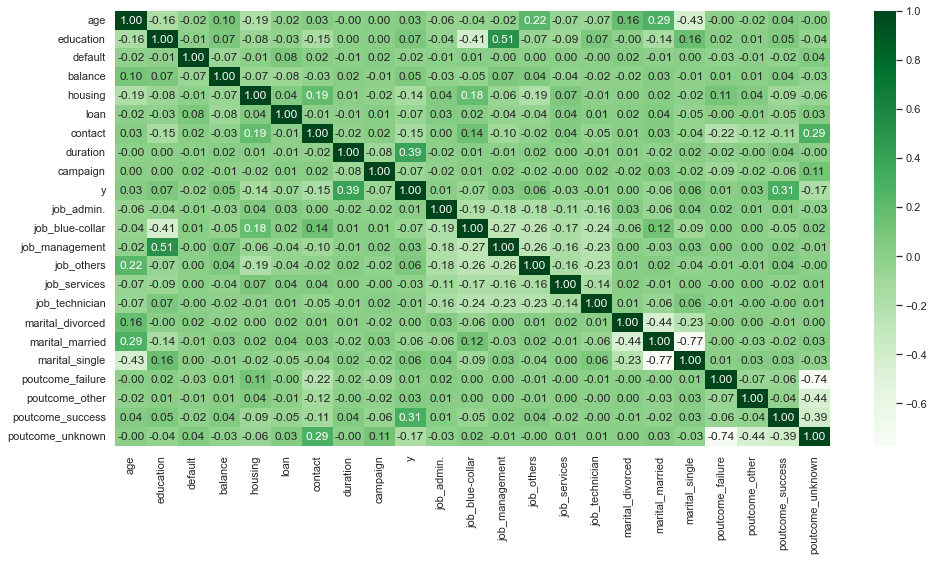

In [29]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), cmap='Greens', annot=True, fmt='.2f')
plt.show()

In [30]:
correlations = df.corr()['y'].sort_values()
correlations

poutcome_unknown   -0.167051
contact            -0.148395
housing            -0.139173
campaign           -0.073172
job_blue-collar    -0.072083
loan               -0.068185
marital_married    -0.060260
job_services       -0.027864
default            -0.022419
job_technician     -0.008970
marital_divorced    0.002772
job_admin.          0.005637
poutcome_failure    0.009885
age                 0.025155
poutcome_other      0.031955
job_management      0.032919
balance             0.052838
marital_single      0.063526
job_others          0.064462
education           0.068633
poutcome_success    0.306788
duration            0.394521
y                   1.000000
Name: y, dtype: float64

Dapat dilihat bahwa tidak ada feature yang berkorelasi kuat dengan Target. Namun terdapat fitur yang redundan yaitu `marital_married` dan `marital_single` serta `poutcome_failure` dan `poutcome_unknown`. Untuk fitur2 yang redundan ini akan digunakan hanya salah satunya.

In [31]:
df.drop(['marital_single','poutcome_unknown'],axis=1,inplace=True)

In [32]:
df

,age,education,default,balance,housing,loan,contact,duration,campaign,y,...,job_blue-collar,job_management,job_others,job_services,job_technician,marital_divorced,marital_married,poutcome_failure,poutcome_other,poutcome_success
0,58,2,0,2143,1,0,2,261,1,0,...,0,1,0,0,0,0,1,0,0,0
1,44,1,0,29,1,0,2,151,1,0,...,0,0,0,0,1,0,0,0,0,0
2,33,1,0,2,1,1,2,76,1,0,...,0,0,1,0,0,0,1,0,0,0
3,47,1,0,1506,1,0,2,92,1,0,...,1,0,0,0,0,0,1,0,0,0
4,33,1,0,1,0,0,2,198,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,2,0,825,0,0,0,977,3,1,...,0,0,0,0,1,0,1,0,0,0
45207,71,0,0,1729,0,0,0,456,2,1,...,0,0,1,0,0,1,0,0,0,0
45208,72,1,0,5715,0,0,0,1127,5,1,...,0,0,1,0,0,0,1,0,0,1
45209,57,1,0,668,0,0,1,508,4,0,...,1,0,0,0,0,0,1,0,0,0


**SPLITTING TRAIN AND TEST DATA**

In [33]:
X = df.drop(['y'],axis=1)
y = data=df['y']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size = 0.2,stratify=y)
print(f'Number of Train Data: {X_train.shape[0]}')
print(f'Number of Test Data: {X_test.shape[0]}')

Number of Train Data: 36168
Number of Test Data: 9043


**RESCALING FEATURES**

In [34]:
#Rescaling train data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
X_train[['age','balance','duration']] = sc.fit_transform(X_train[['age','balance','duration']])

In [35]:
X_test[['age','balance','duration']] = sc.transform(X_test[['age','balance','duration']])

In [36]:
# BEFORE OVERSAMPLING
print(pd.Series(y_train).value_counts())

0    31937
1     4231
Name: y, dtype: int64


**OVERSAMPLING using SMOTE**

Seperti yang dilihat pada saat EDA, kolom TARGET memiliki proporsi yang tidak seimbang. Dimana value 1 ('yes') hanya sekitar 11,7% dari total data. Oleh sebab itu akan dilakukan oversampling terlebih dahulu.

In [37]:
# OVERSAMPLING
from imblearn import over_sampling
X_oversampling , y_oversampling = over_sampling.SMOTE(random_state=42).fit_resample(X_train,y_train)
print(pd.Series(y_oversampling).value_counts())

0    31937
1    31937
Name: y, dtype: int64


## STAGE 3 : MACHINE LEARNING MODELLING & EVALUATION

In [38]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score, confusion_matrix

#Evaluation using train test split
def evaluation(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_oversampling)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_oversampling)
    
    print('**EVALUATION WITH TRAIN TEST SPLIT (OVERSAMPLING)**\nAUC Train vs Test:')
    print('AUC Score Train vs Test:')
    print(f'AUC Score Train proba: {round(roc_auc_score(y_oversampling,y_pred_proba_train[:,1]),6)}')
    print(f'AUC Score Test proba: {round(roc_auc_score(y_test,y_pred_proba[:,1]),6)}\n')
    
    print('Others Metrics Evaluation:')
    print(f'Test Accuracy Score : {round(accuracy_score(y_test,y_pred),4)}')
    print(f'Precision Score Test: {round(precision_score(y_test,y_pred),4)}')
    print(f'Recall Score Test : {round(recall_score(y_test,y_pred),4)}')
    print(f'F1 Score Test : {round(f1_score(y_test,y_pred),4)}\n')
    
    print('**CONFUSION MATRIX**') 
    print(confusion_matrix(y_test, model.predict(X_test)))

In [39]:
from sklearn.model_selection import cross_validate, KFold

#Evaluation using cross validation method
cross_roc_auc_score_lst_train = []
cross_roc_auc_score_lst_test = []
def cross_val_evaluation(model):
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        ssc = StandardScaler()
        scaling_features = ['age','balance','duration']
        X_train[scaling_features] = ssc.fit_transform(X_train[scaling_features])
        X_test[scaling_features] = ssc.transform(X_test[scaling_features])
        X_over, y_over = over_sampling.SMOTE(random_state=42).fit_resample(X_train, y_train)
        model.fit(X_over, y_over)
        print(X_over.shape, y_over.shape)
        y_pred_proba = model.predict_proba(X_test)
        y_pred_proba_train = model.predict_proba(X_over)
        cross_val_roc_auc_score_train = round(roc_auc_score(y_over,y_pred_proba_train[:,1]),3)
        cross_val_roc_auc_score_test = round(roc_auc_score(y_test,y_pred_proba[:,1]),3)
        cross_roc_auc_score_lst_train.append(cross_val_roc_auc_score_train)
        cross_roc_auc_score_lst_test.append(cross_val_roc_auc_score_test)
    print('**EVALUATION CROSS VALIDATION**\nAUC Train vs Test:')
    print(f'AUC Score Cross_Val Proba Train: {round(np.mean(cross_roc_auc_score_lst_train),3)}')
    print(f'AUC Score Cross_Val Proba Test: {round(np.mean(cross_roc_auc_score_lst_test),3)}')   

In [40]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.best_estimator_._final_estimator.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(30).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()
    plt.xlabel('Score')
    plt.ylabel('Features')
    plt.title('Feature Importance Score')

**MODELLING USING VARIOUS ALGORITHM :**

In [41]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(X_oversampling, y_oversampling)

LogisticRegression()

In [42]:
evaluation(model_lr)

**EVALUATION WITH TRAIN TEST SPLIT (OVERSAMPLING)**
AUC Train vs Test:
AUC Score Train vs Test:
AUC Score Train proba: 0.910192
AUC Score Test proba: 0.877333

Others Metrics Evaluation:
Test Accuracy Score : 0.8288
Precision Score Test: 0.3828
Recall Score Test : 0.7561
F1 Score Test : 0.5083

**CONFUSION MATRIX**
[[6695 1290]
 [ 258  800]]


In [43]:
cross_val_evaluation(model_lr)

(62366, 20) (62366,)
(62776, 20) (62776,)
(62870, 20) (62870,)
(63892, 20) (63892,)
(67472, 20) (67472,)
**EVALUATION CROSS VALIDATION**
AUC Train vs Test:
AUC Score Cross_Val Proba Train: 0.912
AUC Score Cross_Val Proba Test: 0.852


**DECISION TREE ALGORITHM**

In [44]:
from sklearn.tree import DecisionTreeClassifier
model_dtree = DecisionTreeClassifier(random_state=42)
model_dtree.fit(X_oversampling,y_oversampling)

DecisionTreeClassifier(random_state=42)

In [45]:
evaluation(model_dtree)

**EVALUATION WITH TRAIN TEST SPLIT (OVERSAMPLING)**
AUC Train vs Test:
AUC Score Train vs Test:
AUC Score Train proba: 1.0
AUC Score Test proba: 0.705645

Others Metrics Evaluation:
Test Accuracy Score : 0.8226
Precision Score Test: 0.3409
Recall Score Test : 0.5529
F1 Score Test : 0.4218

**CONFUSION MATRIX**
[[6854 1131]
 [ 473  585]]


In [46]:
cross_val_evaluation(model_dtree)

(62366, 20) (62366,)
(62776, 20) (62776,)
(62870, 20) (62870,)
(63892, 20) (63892,)
(67472, 20) (67472,)
**EVALUATION CROSS VALIDATION**
AUC Train vs Test:
AUC Score Cross_Val Proba Train: 0.956
AUC Score Cross_Val Proba Test: 0.763


**RANDOM FOREST ALGORITHM**

In [47]:
from sklearn.ensemble import RandomForestClassifier
model_rforest = RandomForestClassifier(random_state=42)
model_rforest.fit(X_oversampling,y_oversampling)

RandomForestClassifier(random_state=42)

In [48]:
evaluation(model_rforest)

**EVALUATION WITH TRAIN TEST SPLIT (OVERSAMPLING)**
AUC Train vs Test:
AUC Score Train vs Test:
AUC Score Train proba: 1.0
AUC Score Test proba: 0.882606

Others Metrics Evaluation:
Test Accuracy Score : 0.8602
Precision Score Test: 0.4345
Recall Score Test : 0.6456
F1 Score Test : 0.5194

**CONFUSION MATRIX**
[[7096  889]
 [ 375  683]]


In [49]:
cross_val_evaluation(model_rforest)

(62366, 20) (62366,)
(62776, 20) (62776,)
(62870, 20) (62870,)
(63892, 20) (63892,)
(67472, 20) (67472,)
**EVALUATION CROSS VALIDATION**
AUC Train vs Test:
AUC Score Cross_Val Proba Train: 0.971
AUC Score Cross_Val Proba Test: 0.791


**ADABOOST CLASSIFIER ALGORITHM**

In [50]:
from sklearn.ensemble import AdaBoostClassifier
model_adaboost = AdaBoostClassifier(random_state=42)
model_adaboost.fit(X_oversampling,y_oversampling)

AdaBoostClassifier(random_state=42)

In [51]:
evaluation(model_adaboost)

**EVALUATION WITH TRAIN TEST SPLIT (OVERSAMPLING)**
AUC Train vs Test:
AUC Score Train vs Test:
AUC Score Train proba: 0.917353
AUC Score Test proba: 0.882437

Others Metrics Evaluation:
Test Accuracy Score : 0.8266
Precision Score Test: 0.3808
Recall Score Test : 0.7703
F1 Score Test : 0.5097

**CONFUSION MATRIX**
[[6660 1325]
 [ 243  815]]


In [52]:
cross_val_evaluation(model_adaboost)

(62366, 20) (62366,)
(62776, 20) (62776,)
(62870, 20) (62870,)
(63892, 20) (63892,)
(67472, 20) (67472,)
**EVALUATION CROSS VALIDATION**
AUC Train vs Test:
AUC Score Cross_Val Proba Train: 0.958
AUC Score Cross_Val Proba Test: 0.807


**XGBOOST CLASSIFIER ALGORITHM**

In [53]:
from xgboost import XGBClassifier

model_xgboost = XGBClassifier(random_state=42)
model_xgboost.fit(X_oversampling, y_oversampling)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [54]:
evaluation(model_xgboost)

**EVALUATION WITH TRAIN TEST SPLIT (OVERSAMPLING)**
AUC Train vs Test:
AUC Score Train vs Test:
AUC Score Train proba: 0.990017
AUC Score Test proba: 0.889099

Others Metrics Evaluation:
Test Accuracy Score : 0.885
Precision Score Test: 0.5081
Recall Score Test : 0.5359
F1 Score Test : 0.5216

**CONFUSION MATRIX**
[[7436  549]
 [ 491  567]]


In [55]:
cross_val_evaluation(model_xgboost)

(62366, 20) (62366,)
(62776, 20) (62776,)
(62870, 20) (62870,)
(63892, 20) (63892,)
(67472, 20) (67472,)
**EVALUATION CROSS VALIDATION**
AUC Train vs Test:
AUC Score Cross_Val Proba Train: 0.964
AUC Score Cross_Val Proba Test: 0.817


## Evaluasi Sementara :

* Ketika melakukan evaluasi dengan pendekatan train_test_split maupun pendekatan cross validation (membandingkan auc score antara train dan test) dapat dilihat semua model masih overfitting, akan dilakukan hyperparameter tuning untuk mengurangi overfitting tersebut. Setelah selesai melakukan hyperparameter tuning akan dipilih model terbaik dari antara ke-5 model tersebut.

* Dalam kasus ini kami ingin lebih memaksimalkan recall score dibandingkan dengan precission. Recall score yang tinggi dapat diartikan bahwa model memiliki tingkat False Negatif yang rendah sehingga dapat dikatakan bahwa opportunity loss yang rendah dan akan sejalan dengan goal yang ditetapkan diawal yaitu ingin meningkatkan conversion rate. **(False Negatif : diklasifikasikan tidak tertarik mendaftar deposito tapi sebenarnya tertarik mendaftar deposito)**.

## **HYPERPARAMETER TUNING:**

In [56]:
#Evaluation for tuned model
def evaluation_tuned(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print('**EVALUATION WITH TRAIN TEST SPLIT (PIPELINE)**\nAUC Train vs Test:')
    print('AUC Score Train vs Test:')
    print(f'AUC Score Train proba: {round(roc_auc_score(y_train,y_pred_proba_train[:,1]),6)}')
    print(f'AUC Score Test proba: {round(roc_auc_score(y_test,y_pred_proba[:,1]),6)}\n')
    
    print('Others Metrics Evaluation:')
    print(f'Test Accuracy Score : {round(accuracy_score(y_test,y_pred),4)}')
    print(f'Precision Score Test: {round(precision_score(y_test,y_pred),4)}')
    print(f'Recall Score Test : {round(recall_score(y_test,y_pred),4)}')
    print(f'F1 Score Test : {round(f1_score(y_test,y_pred),4)}\n')
    
    print('**CONFUSION MATRIX**') 
    print(confusion_matrix(y_test, model.predict(X_test)))

**LOGISTIC REGRESSION ALGORITHM**

In [57]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE

pipeline_logreg = Pipeline([('smt', SMOTE(random_state=42)),
                            ('logreg', LogisticRegression())])

logreg_hyparameters = {"logreg__penalty": ['l1', 'l2'],
                       "logreg__C":[float(x) for x in np.linspace(0.001, 10, 100)]}

tuned_logreg = RandomizedSearchCV(pipeline_logreg, logreg_hyparameters, cv = 5,
                                  random_state=42, n_jobs=-1, scoring='recall')
tuned_logreg.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smt', SMOTE(random_state=42)),
                                             ('logreg', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'logreg__C': [0.001,
                                                      0.10200000000000001,
                                                      0.203,
                                                      0.30400000000000005,
                                                      0.405, 0.506,
                                                      0.6070000000000001,
                                                      0.7080000000000001, 0.809,
                                                      0.91, 1.011,
                                                      1.1119999999999999, 1.213,
                                                      1.314, 1.415, 1.516,
                                                      1.617, 1.718, 1.819, 1.92,
                                                      2.021, 2.122, 2.223,
                                                      2.324, 2.4250000000000003,
                                                      2.5260000000000002,
                                                      2.6270000000000002, 2.728,
                                                      2.829, 2.93, ...],
                                        'logreg__penalty': ['l1', 'l2']},
                   random_state=42, scoring='recall')

In [58]:
print(f'Best Parameter: {tuned_logreg.best_params_}')

Best Parameter: {'logreg__penalty': 'l2', 'logreg__C': 0.7080000000000001}


In [59]:
evaluation_tuned(tuned_logreg)

**EVALUATION WITH TRAIN TEST SPLIT (PIPELINE)**
AUC Train vs Test:
AUC Score Train vs Test:
AUC Score Train proba: 0.876195
AUC Score Test proba: 0.877409

Others Metrics Evaluation:
Test Accuracy Score : 0.8286
Precision Score Test: 0.3824
Recall Score Test : 0.7561
F1 Score Test : 0.5079

**CONFUSION MATRIX**
[[6693 1292]
 [ 258  800]]


**DECISION TREE ALGORITHM**

In [60]:
pipeline_dtree= Pipeline([('smt', SMOTE(random_state=42)),
                          ('dtree', DecisionTreeClassifier(random_state=42))])

dtree_hyparameters = {"dtree__criterion":['gini','entropy'],
                      "dtree__max_depth":[5,9,14,21,24],
                      "dtree__min_samples_split":[2,5,10,50,100],
                      "dtree__min_samples_leaf":[2,5,10,50,100],
                      "dtree__max_features":['auto','sqrt']}

tuned_dtree = RandomizedSearchCV(pipeline_dtree, dtree_hyparameters, cv = 5,
                                  random_state=42, n_jobs=-1, scoring='recall')
tuned_dtree.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smt', SMOTE(random_state=42)),
                                             ('dtree',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'dtree__criterion': ['gini', 'entropy'],
                                        'dtree__max_depth': [5, 9, 14, 21, 24],
                                        'dtree__max_features': ['auto', 'sqrt'],
                                        'dtree__min_samples_leaf': [2, 5, 10,
                                                                    50, 100],
                                        'dtree__min_samples_split': [2, 5, 10,
                                                                     50, 100]},
                   random_state=42, scoring='recall')

In [61]:
print(f'Best Parameter: {tuned_dtree.best_params_}')

Best Parameter: {'dtree__min_samples_split': 50, 'dtree__min_samples_leaf': 50, 'dtree__max_features': 'auto', 'dtree__max_depth': 9, 'dtree__criterion': 'gini'}


In [62]:
evaluation_tuned(tuned_dtree)

**EVALUATION WITH TRAIN TEST SPLIT (PIPELINE)**
AUC Train vs Test:
AUC Score Train vs Test:
AUC Score Train proba: 0.833931
AUC Score Test proba: 0.814195

Others Metrics Evaluation:
Test Accuracy Score : 0.7417
Precision Score Test: 0.2739
Recall Score Test : 0.7316
F1 Score Test : 0.3986

**CONFUSION MATRIX**
[[5933 2052]
 [ 284  774]]


**RANDOM FOREST ALGORITHM**

In [63]:
pipeline_rforest= Pipeline([('smt', SMOTE(random_state=42)),
                            ('rforest', RandomForestClassifier(random_state=42))])

rforest_hyparameters = {"rforest__n_estimators":[5,9,11,17],
                        "rforest__criterion":['gini','entropy'],
                        "rforest__max_depth":[int(x) for x in np.linspace(5, 20, 5)],
                        "rforest__min_samples_split":[int(x) for x in np.linspace(5, 100, 10)],
                        "rforest__min_samples_leaf":[int(x) for x in np.linspace(5, 100, 10)],
                        "rforest__max_features":['auto','sqrt']}

tuned_rforest = RandomizedSearchCV(pipeline_rforest, rforest_hyparameters, cv = 5,
                                   random_state=42, n_jobs=-1, scoring='recall')
tuned_rforest.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smt', SMOTE(random_state=42)),
                                             ('rforest',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'rforest__criterion': ['gini',
                                                               'entropy'],
                                        'rforest__max_depth': [5, 8, 12, 16,
                                                               20],
                                        'rforest__max_features': ['auto',
                                                                  'sqrt'],
                                        'rforest__min_samples_leaf': [5, 15, 26,
                                                                      36, 47,
                                                                      57, 68,
                                                                      78, 89,
                                                                      100],
                                        'rforest__min_samples_split': [5, 15,
                                                                       26, 36,
                                                                       47, 57,
                                                                       68, 78,
                                                                       89,
                                                                       100],
                                        'rforest__n_estimators': [5, 9, 11,
                                                                  17]},
                   random_state=42, scoring='recall')

In [64]:
print(f'Best Parameter: {tuned_rforest.best_params_}')

Best Parameter: {'rforest__n_estimators': 17, 'rforest__min_samples_split': 78, 'rforest__min_samples_leaf': 100, 'rforest__max_features': 'auto', 'rforest__max_depth': 8, 'rforest__criterion': 'entropy'}


In [65]:
evaluation_tuned(tuned_rforest)

**EVALUATION WITH TRAIN TEST SPLIT (PIPELINE)**
AUC Train vs Test:
AUC Score Train vs Test:
AUC Score Train proba: 0.888927
AUC Score Test proba: 0.879889

Others Metrics Evaluation:
Test Accuracy Score : 0.8003
Precision Score Test: 0.3472
Recall Score Test : 0.8034
F1 Score Test : 0.4849

**CONFUSION MATRIX**
[[6387 1598]
 [ 208  850]]


**ADABOOST CLASSIFIER ALGORITHM**

In [66]:
pipeline_adaboost = Pipeline([('smt', SMOTE(random_state=42)),
                              ('adaboost', AdaBoostClassifier(random_state=42))])

adaboost_hyparameters = {"adaboost__n_estimators":[int(x) for x in np.linspace(30, 500, 10)],
                         "adaboost__learning_rate":[float(x) for x in np.linspace(0.01, 1, 10)],
                         "adaboost__algorithm":['SAMME.R','SAMME']}

tuned_adaboost = RandomizedSearchCV(pipeline_adaboost, adaboost_hyparameters, cv = 5,
                                    random_state=42, n_jobs=-1, scoring='recall')
tuned_adaboost.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smt', SMOTE(random_state=42)),
                                             ('adaboost',
                                              AdaBoostClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'adaboost__algorithm': ['SAMME.R',
                                                                'SAMME'],
                                        'adaboost__learning_rate': [0.01, 0.12,
                                                                    0.23, 0.34,
                                                                    0.45, 0.56,
                                                                    0.67, 0.78,
                                                                    0.89, 1.0],
                                        'adaboost__n_estimators': [30, 82, 134,
                                                                   186, 238,
                                                                   291, 343,
                                                                   395, 447,
                                                                   500]},
                   random_state=42, scoring='recall')

In [67]:
print(f'Best Parameter: {tuned_adaboost.best_params_}')

Best Parameter: {'adaboost__n_estimators': 291, 'adaboost__learning_rate': 0.12, 'adaboost__algorithm': 'SAMME'}


In [68]:
evaluation_tuned(tuned_adaboost)

**EVALUATION WITH TRAIN TEST SPLIT (PIPELINE)**
AUC Train vs Test:
AUC Score Train vs Test:
AUC Score Train proba: 0.887415
AUC Score Test proba: 0.885903

Others Metrics Evaluation:
Test Accuracy Score : 0.8077
Precision Score Test: 0.3589
Recall Score Test : 0.8185
F1 Score Test : 0.499

**CONFUSION MATRIX**
[[6438 1547]
 [ 192  866]]


**XGBOOST CLASSIFIER ALGORITHM**

In [69]:
pipeline_xgboost = Pipeline([('smt', SMOTE(random_state=42)),
                             ('xgboost', XGBClassifier(random_state=42))])



xgboost_hyparameters = {'xgboost__max_depth' : [int(x) for x in np.linspace(3,30,5)],
                        'xgboost__min_child_weight' : [int(x) for x in np.linspace(1,10,11)],
                        'xgboost__gamma' : [float(x) for x in np.linspace(0,1,11)],
                        'xgboost__tree_method' : ['auto', 'exact', 'approx', 'hist'],
                        'xgboost__colsample_bytree' : [float(x) for x in np.linspace(0,1,11)],
                        'xgboost__eta' : [float(x) for x in np.linspace(0,1,100)],
                        'xgboost__lambda' : [float(x) for x in np.linspace(0,1,11)],
                        'xgboost__alpha' : [float(x) for x in np.linspace(0,1,11)]}

tuned_xgboost = RandomizedSearchCV(pipeline_xgboost, xgboost_hyparameters, cv = 5,
                                   random_state=42, n_jobs=-1, scoring='recall')
tuned_xgboost.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smt', SMOTE(random_state=42)),
                                             ('xgboost',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            grow_policy=None,
                                                            importance_type=None,
                                                            int...
                                                           0.30000000000000004,
                                                           0.4, 0.5,
                                                           0.6000000000000001,
                                                           0.7000000000000001,
                                                           0.8, 0.9, 1.0],
                                        'xgboost__lambda': [0.0, 0.1, 0.2,
                                                            0.30000000000000004,
                                                            0.4, 0.5,
                                                            0.6000000000000001,
                                                            0.7000000000000001,
                                                            0.8, 0.9, 1.0],
                                        'xgboost__max_depth': [3, 9, 16, 23,
                                                               30],
                                        'xgboost__min_child_weight': [1, 1, 2,
                                                                      3, 4, 5,
                                                                      6, 7, 8,
                                                                      9, 10],
                                        'xgboost__tree_method': ['auto',
                                                                 'exact',
                                                                 'approx',
                                                                 'hist']},
                   random_state=42, scoring='recall')

In [70]:
print(f'Best Parameter: {tuned_xgboost.best_params_}')

Best Parameter: {'xgboost__tree_method': 'hist', 'xgboost__min_child_weight': 3, 'xgboost__max_depth': 3, 'xgboost__lambda': 0.6000000000000001, 'xgboost__gamma': 0.4, 'xgboost__eta': 0.09090909090909091, 'xgboost__colsample_bytree': 0.9, 'xgboost__alpha': 0.6000000000000001}


In [71]:
evaluation_tuned(tuned_xgboost)

**EVALUATION WITH TRAIN TEST SPLIT (PIPELINE)**
AUC Train vs Test:
AUC Score Train vs Test:
AUC Score Train proba: 0.902308
AUC Score Test proba: 0.893103

Others Metrics Evaluation:
Test Accuracy Score : 0.8188
Precision Score Test: 0.3746
Recall Score Test : 0.8204
F1 Score Test : 0.5144

**CONFUSION MATRIX**
[[6536 1449]
 [ 190  868]]


In [72]:
#confusion matrix after hyperparameter tuning
logreg_cm = confusion_matrix(y_test, tuned_logreg.predict(X_test))
dtree_cm = confusion_matrix(y_test, tuned_dtree.predict(X_test))
rforest_cm = confusion_matrix(y_test, tuned_rforest.predict(X_test))
adaboost_cm = confusion_matrix(y_test, tuned_adaboost.predict(X_test))
xgboost_cm = confusion_matrix(y_test, tuned_xgboost.predict(X_test))

In [73]:
def dataframe_to_plot(title, classification_cm) -> pd.DataFrame:
    tn, fp, fn, tp = classification_cm.ravel()
    
    accuracy = round(((tp+tn) / (tn + tp + fn + fp)),4)
    sensitivity = round((tp / (fn + tp)),4)
    precision = round((tp / (tp + fp)),4)
    f1 = round(((2 * (1/((1/precision) + (1/sensitivity))))), 4)
    
    foo = pd.DataFrame(data=[f1, accuracy, sensitivity, precision], 
             columns=[title],
             index=["F1","Accuracy", "Recall", "Precision"])
    
    return foo

logreg_df = dataframe_to_plot('Tuned Logistic Regression', logreg_cm)
dtree_df = dataframe_to_plot('Tuned Decision Tree', dtree_cm)
rforest_df = dataframe_to_plot('Tuned Random Forest', rforest_cm)
adaboost_df = dataframe_to_plot('Tuned Adaboost', adaboost_cm)
xgboost_df = dataframe_to_plot('Tuned XGBoost', xgboost_cm)

In [74]:
add_eval_logreg = pd.DataFrame(data=[round(roc_auc_score(y_train,(tuned_logreg.predict_proba(X_train))[:,1]),5),
                                     round(roc_auc_score(y_test,(tuned_logreg.predict_proba(X_test))[:,1]),5)],
                               columns = ['Tuned Logistic Regression'],
                               index=['AUC-Proba Train','AUC-Proba Test'])

add_eval_dtree = pd.DataFrame(data=[round(roc_auc_score(y_train,(tuned_dtree.predict_proba(X_train))[:,1]),5),
                                     round(roc_auc_score(y_test,(tuned_dtree.predict_proba(X_test))[:,1]),5)],
                               columns = ['Tuned Decision Tree'],
                               index=['AUC-Proba Train','AUC-Proba Test'])

add_eval_rforest = pd.DataFrame(data=[round(roc_auc_score(y_train,(tuned_rforest.predict_proba(X_train))[:,1]),5),
                                     round(roc_auc_score(y_test,(tuned_rforest.predict_proba(X_test))[:,1]),5)],
                               columns = ['Tuned Random Forest'],
                               index=['AUC-Proba Train','AUC-Proba Test'])

add_eval_adaboost = pd.DataFrame(data=[round(roc_auc_score(y_train,(tuned_adaboost.predict_proba(X_train))[:,1]),5),
                                     round(roc_auc_score(y_test,(tuned_adaboost.predict_proba(X_test))[:,1]),5)],
                               columns = ['Tuned Adaboost'],
                               index=['AUC-Proba Train','AUC-Proba Test'])


add_eval_xgboost = pd.DataFrame(data=[round(roc_auc_score(y_train,(tuned_xgboost.predict_proba(X_train))[:,1]),5),
                                      round(roc_auc_score(y_test,(tuned_xgboost.predict_proba(X_test))[:,1]),5)],
                                columns = ['Tuned XGBoost'],
                                index=['AUC-Proba Train','AUC-Proba Test'])

In [75]:
logreg_df = pd.concat([add_eval_logreg,logreg_df])
dtree_df = pd.concat([add_eval_dtree,dtree_df])
rforest_df = pd.concat([add_eval_rforest,rforest_df])
adaboost_df = pd.concat([add_eval_adaboost,adaboost_df])
xgboost_df = pd.concat([add_eval_xgboost,xgboost_df])

In [76]:
logreg_df = logreg_df.reindex(["AUC-Proba Train", "AUC-Proba Test","Recall","Precision","F1","Accuracy"])
dtree_df = dtree_df.reindex(["AUC-Proba Train", "AUC-Proba Test","Recall","Precision","F1","Accuracy"])
rforest_df = rforest_df.reindex(["AUC-Proba Train", "AUC-Proba Test","Recall","Precision","F1","Accuracy"])
adaboost_df = adaboost_df.reindex(["AUC-Proba Train", "AUC-Proba Test","Recall","Precision","F1","Accuracy"])
xgboost_df = xgboost_df.reindex(["AUC-Proba Train", "AUC-Proba Test","Recall","Precision","F1","Accuracy"])

In [77]:
class Colors:
    LightGray = "#fafafa"
    Teal = "#008080"
    LightCyan = "#badbdb"

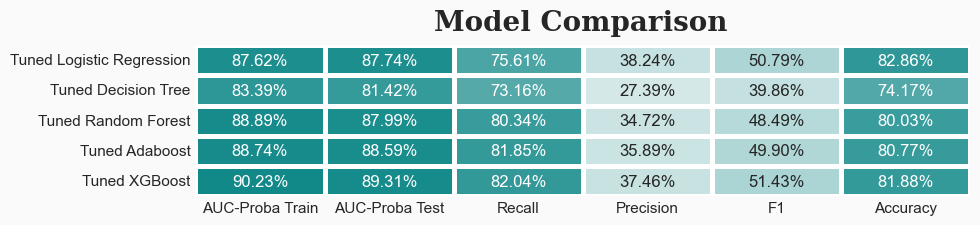

In [78]:
import matplotlib
df_models = round(pd.concat([logreg_df, dtree_df, rforest_df, adaboost_df, xgboost_df], axis=1),4)
colors = [Colors.LightGray, Colors.LightCyan, Colors.Teal]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


fig = plt.figure(figsize=(10,8),dpi=100, facecolor=Colors.LightGray) # create figure
gs = fig.add_gridspec(3, 2, wspace=0.1, hspace=0.5)

ax0 = fig.add_subplot(gs[0:1, :])

sns.heatmap(df_models.T, cmap=colormap, annot=True,fmt=".2%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(Colors.LightGray) 
ax0.set_facecolor(Colors.LightGray)
ax0.tick_params(axis=u'both', which=u'both',length=0)

ax0.text(1.85,-0.5,'Model Comparison',fontsize=20,fontweight='bold',fontfamily='serif')

fig.show()

Dari ke 5 model diatas diputuskan bahwa model yang akan dipilih adaleh model XGBoost yang sudah dilakukan tuning hyperparameter dikarenakan alasan berikut ini :
* Memiliki hasil score evaluasi AUC-Proba Test tertinggi yaitu 89.65%
* Gap score evaluasi AUC-Proba Train dan AUC-Proba Test cukup rendah yaitu sekitar 0.6%.
* Memiliki hasil score evaluasi Recall yang terbaik yaitu 82.68% dimana pada kasus kali ini tujuannya adalah meningkatkan nasabah yang akan mendaftar deposito berjangka sehingga harus memaksimalkan score evaluasi Recall tetapi dengan catatan metrics evaluasi AUC juga harus diperhatikan.

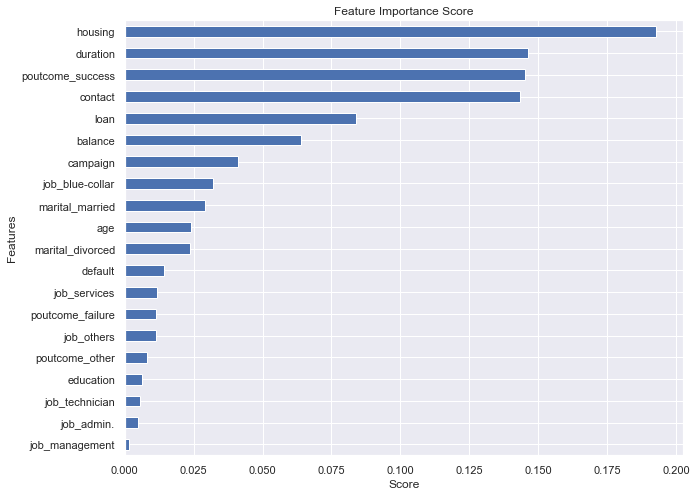

In [79]:
show_feature_importance(tuned_xgboost)

In [80]:
#Coba buang feature yang importance score < 0.025 (selain age & marital divorced krn masih mendekati 0.025)
X_new = df.drop(['default','job_admin.','job_others',
              'job_technician','job_services','poutcome_failure','poutcome_other',
              'education','job_management','y'],axis=1)
y_new = df['y']

In [81]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, random_state=42, test_size = 0.2,stratify=y)
print(f'Jumlah Data Train : {X_train_new.shape[0]}')
print(f'Jumlah Data Test: {X_test_new.shape[0]}')

Jumlah Data Train : 36168
Jumlah Data Test: 9043


In [82]:
X_train_std = X_train_new.copy()
X_test_std = X_test_new.copy()
X_train_std[['age','balance','duration']] = sc.fit_transform(X_train_new[['age','balance','duration']])
X_test_std[['age','balance','duration']] = sc.transform(X_test_new[['age','balance','duration']])

In [83]:
#Evaluation for tuned model (oversampling using pipeline)
def evaluation_feature_importance(model):
    y_pred = model.predict(X_test_std)
    y_pred_train = model.predict(X_train_std)
    y_pred_proba = model.predict_proba(X_test_std)
    y_pred_proba_train = model.predict_proba(X_train_std)
    
    print('**EVALUATION WITH TRAIN TEST SPLIT (PIPELINE)**\nAUC Train vs Test:')
    print('AUC Score Train vs Test:')
    print(f'AUC Score Train proba: {round(roc_auc_score(y_train_new,y_pred_proba_train[:,1]),6)}')
    print(f'AUC Score Test proba: {round(roc_auc_score(y_test_new,y_pred_proba[:,1]),6)}\n')
    
    print('Others Metrics Evaluation:')
    print(f'Test Accuracy Score : {round(accuracy_score(y_test_new,y_pred),4)}')
    print(f'Precision Score Test: {round(precision_score(y_test_new,y_pred),4)}')
    print(f'Recall Score Test : {round(recall_score(y_test_new,y_pred),4)}')
    print(f'F1 Score Test : {round(f1_score(y_test_new,y_pred),4)}\n')
    
    print('**CONFUSION MATRIX**') 
    print(confusion_matrix(y_test_new, model.predict(X_test_std)))

In [84]:
pipeline_newxgboost = Pipeline([('smt', SMOTE(random_state=42)),
                                ('xgboostnew', XGBClassifier(random_state=42))])



newxgboost_hyparameters = {'xgboostnew__max_depth' : [int(x) for x in np.linspace(3,30,5)],
                           'xgboostnew__min_child_weight' : [int(x) for x in np.linspace(1,10,11)],
                           'xgboostnew__gamma' : [float(x) for x in np.linspace(0,1,11)],
                           'xgboostnew__tree_method' : ['auto', 'exact', 'approx', 'hist'],
                           'xgboostnew__colsample_bytree' : [float(x) for x in np.linspace(0,1,11)],
                           'xgboostnew__eta' : [float(x) for x in np.linspace(0,1,100)],
                           'xgboostnew__lambda' : [float(x) for x in np.linspace(0,1,11)],
                           'xgboostnew__alpha' : [float(x) for x in np.linspace(0,1,11)]}

new_xgboost = RandomizedSearchCV(pipeline_newxgboost, newxgboost_hyparameters, cv = 5,
                                   random_state=42, n_jobs=-1, scoring='recall')
new_xgboost.fit(X_train_std,y_train_new)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smt', SMOTE(random_state=42)),
                                             ('xgboostnew',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            grow_policy=None,
                                                            importance_type=None,...
                                                              0.6000000000000001,
                                                              0.7000000000000001,
                                                              0.8, 0.9, 1.0],
                                        'xgboostnew__lambda': [0.0, 0.1, 0.2,
                                                               0.30000000000000004,
                                                               0.4, 0.5,
                                                               0.6000000000000001,
                                                               0.7000000000000001,
                                                               0.8, 0.9, 1.0],
                                        'xgboostnew__max_depth': [3, 9, 16, 23,
                                                                  30],
                                        'xgboostnew__min_child_weight': [1, 1,
                                                                         2, 3,
                                                                         4, 5,
                                                                         6, 7,
                                                                         8, 9,
                                                                         10],
                                        'xgboostnew__tree_method': ['auto',
                                                                    'exact',
                                                                    'approx',
                                                                    'hist']},
                   random_state=42, scoring='recall')

In [85]:
print(f'Best Parameter: {new_xgboost.best_params_}')

Best Parameter: {'xgboostnew__tree_method': 'hist', 'xgboostnew__min_child_weight': 3, 'xgboostnew__max_depth': 3, 'xgboostnew__lambda': 0.6000000000000001, 'xgboostnew__gamma': 0.4, 'xgboostnew__eta': 0.09090909090909091, 'xgboostnew__colsample_bytree': 0.9, 'xgboostnew__alpha': 0.6000000000000001}


In [86]:
evaluation_feature_importance(new_xgboost)

**EVALUATION WITH TRAIN TEST SPLIT (PIPELINE)**
AUC Train vs Test:
AUC Score Train vs Test:
AUC Score Train proba: 0.903776
AUC Score Test proba: 0.895811

Others Metrics Evaluation:
Test Accuracy Score : 0.8121
Precision Score Test: 0.3664
Recall Score Test : 0.8308
F1 Score Test : 0.5085

**CONFUSION MATRIX**
[[6465 1520]
 [ 179  879]]


Dapat dilihat bahwa pengurangan jumlah feature yang memiliki feature importance score < 0.025 pada pemodelan XGBoost berdampak pada peningkatan sekitar 0.2% pada Recall. Dimana AUC Score test juga mengalami peningkatan meskipun tidak terlalu signifikan. Oleh sebab itu untuk **pemodelan yang digunakan adalah model XGBoost yang sudah dibuang feature yang memiliki feature importance score < 0.025**

## **FINAL MODEL**

In [87]:
# OVERSAMPLING
from imblearn import over_sampling
X_oversampling , y_oversampling = over_sampling.SMOTE(random_state=42).fit_resample(X_train_std,y_train_new)
print(pd.Series(y_oversampling).value_counts())

0    31937
1    31937
Name: y, dtype: int64


In [88]:
#USING HYPERPARAMETER RESULT FROM TUNING
final_model = XGBClassifier(random_state=42, tree_method= 'hist', min_child_weight= 3, max_depth = 3,
                              reg_lambda = 0.6000000000000001, gamma= 0.4, eta= 0.09090909090909091, colsample_bytree=0.9, 
                              alpha= 0.6000000000000001)


final_model.fit(X_oversampling, y_oversampling)

XGBClassifier(alpha=0.6000000000000001, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eta=0.09090909090909091,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0909090936, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [89]:
y_pred = final_model.predict(X_test[X_oversampling.columns])
y_pred_train = final_model.predict(X_oversampling)
y_pred_proba = final_model.predict_proba(X_test[X_oversampling.columns])
y_pred_proba_train = final_model.predict_proba(X_oversampling)

model_final = pd.DataFrame(data=[round(roc_auc_score(y_test,y_pred_proba[:,1]),5),
                                 round(recall_score(y_test,y_pred),4),
                                 round(precision_score(y_test,y_pred),4),
                                 round(f1_score(y_test,y_pred),4),
                                 round(accuracy_score(y_test,y_pred),4)],
                                columns = [' '],
                                index=['AUC-Proba','Recall','Precision','F1','Accuracy'])

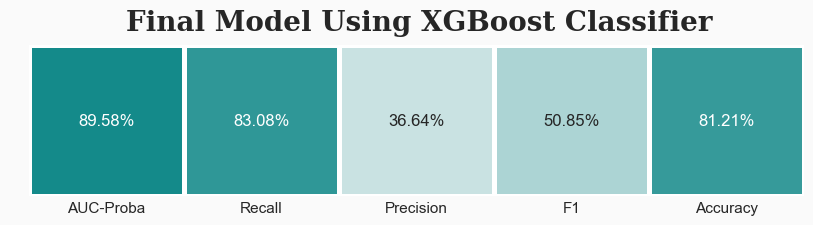

In [90]:
import matplotlib
df_models = round(pd.concat([model_final], axis=1),4)
colors = [Colors.LightGray, Colors.LightCyan, Colors.Teal]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


fig = plt.figure(figsize=(10,8),dpi=100, facecolor=Colors.LightGray) # create figure
gs = fig.add_gridspec(3, 2, wspace=0.1, hspace=0.5)

ax0 = fig.add_subplot(gs[0:1, :])

sns.heatmap(df_models.T, cmap=colormap, annot=True,fmt=".2%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(Colors.LightGray) 
ax0.set_facecolor(Colors.LightGray)
ax0.tick_params(axis=u'both', which=u'both',length=0)

ax0.text(0.625,-0.1,'Final Model Using XGBoost Classifier',fontsize=20,fontweight='bold',fontfamily='serif')

fig.show()

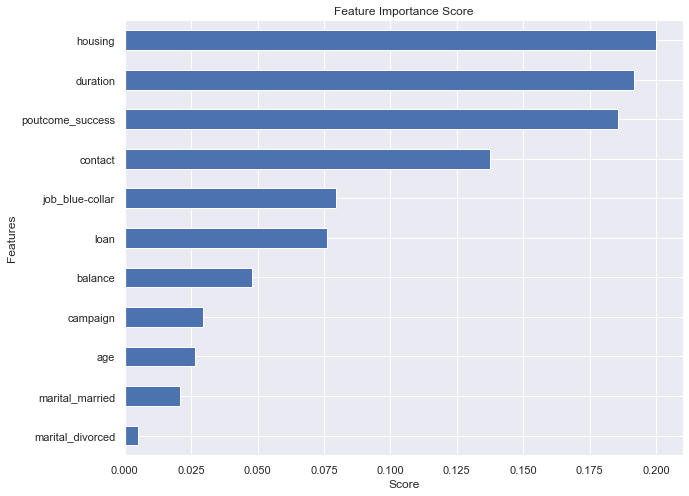

In [91]:
feat_importances = pd.Series(final_model.feature_importances_, index=X_new.columns)
ax = feat_importances.nlargest(30).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()
plt.xlabel('Score')
plt.ylabel('Features')
plt.title('Feature Importance Score')
plt.show()

## **FEATURE IMPORTANCE INTERPRETATION**

**POUTCOME_SUCCESS:**

In [92]:
X_prediction_result = X_test_new.copy()
X_prediction_result['Prediction Result'] = y_pred

In [93]:
X_prediction_result

,age,balance,housing,loan,contact,duration,campaign,job_blue-collar,marital_divorced,marital_married,poutcome_success,Prediction Result
1392,40,640,1,1,2,347,2,1,0,1,0,0
7518,44,378,1,0,2,203,2,0,0,1,0,0
12007,31,356,1,0,2,228,5,0,0,1,0,0
5536,36,655,1,0,2,153,4,1,0,1,0,0
29816,34,1921,1,0,0,61,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12636,26,-333,0,1,2,692,1,1,0,0,0,1
13364,49,884,1,0,1,201,3,0,0,1,0,0
16102,32,964,1,0,0,370,2,0,0,1,0,1
42097,20,0,0,0,0,69,4,0,0,0,0,0


In [94]:
poutcome_df = X_prediction_result.groupby(['Prediction Result','poutcome_success']).agg({'poutcome_success':'count'})
poutcome_df.columns = ['Jumlah']
poutcome_df.reset_index(inplace=True)

In [95]:
prediction_outcome_df = X_prediction_result.groupby(['Prediction Result']).agg({'Prediction Result':'count'})
prediction_outcome_df.columns = ['Number of Each Group']
prediction_outcome_df.reset_index(inplace=True)

In [96]:
prediction_outcome_df

,Prediction Result,Number of Each Group
0,0,6644
1,1,2399


In [97]:
poutcome_df

,Prediction Result,poutcome_success,Jumlah
0,0,0,6615
1,0,1,29
2,1,0,2122
3,1,1,277


In [98]:
visualization_poutcome = poutcome_df.merge(prediction_outcome_df, on = 'Prediction Result')

In [99]:
visualization_poutcome['Ratio'] = round((visualization_poutcome['Jumlah']/visualization_poutcome['Number of Each Group']) * 100 ,2)

In [100]:
visualization_poutcome
visualization_poutcome.reset_index(drop=True)

,Prediction Result,poutcome_success,Jumlah,Number of Each Group,Ratio
0,0,0,6615,6644,99.56
1,0,1,29,6644,0.44
2,1,0,2122,2399,88.45
3,1,1,277,2399,11.55


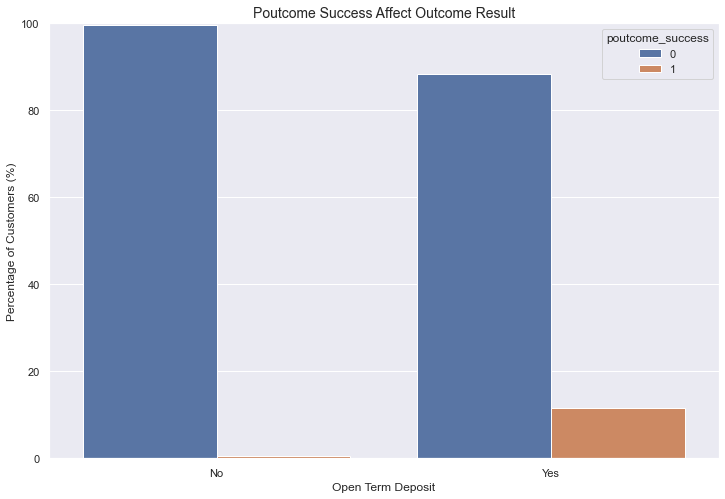

In [101]:
plt.figure(figsize=(12,8))
sns.barplot(x=visualization_poutcome['Prediction Result'],
            y=visualization_poutcome['Ratio'],hue=visualization_poutcome['poutcome_success'])
plt.title('Poutcome Success Affect Outcome Result',fontsize=14)
plt.xlabel('Open Term Deposit',fontsize=12)
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('Percentage of Customers (%)',fontsize=12)
plt.ylim(0,100)
plt.show()

* Dapat dilihat bahwa customer yang memutuskan membuka deposit sekitar 11% customer tersebut juga mengikuti campaign sebelumnya yang ditawarkan oleh pihak bank. Artinya bahwa hasil campaign2 yang selama ini ditawarkan oleh pihak bank ternyata cukup memberikan andil dalam mempengaruhi keputusan customer terhadap campaign kali ini. Oleh karena itu pihak bank mulai dari sekarang harus mulai memaksimalkan setiap campaign yang ada kepada para customer. Mungkin dengan cara memberikan tawaran2 menarik misal campaign KPR --> berikan bunga murah, campaign pinjaman usaha --> berikan biaya provisi yang tidak terlalu besar. Dengan demikian ketika para customer sudah pernah mengikut campaign2 yg ditawarkan bank pada periode sebelumnya, customer tidak akan terlalu ragu dalam mengikuti campaign2 berikutnya yang ditawarkan oleh bank karena customer merasa bahwa pihak bank selalu memberikan tawaran2 yang menarik.

**DURATION:**

In [102]:
X_prediction_result['duration'].describe()

count    9043.000000
mean      256.787792
std       250.975509
min         0.000000
25%       103.000000
50%       179.000000
75%       322.000000
max      3284.000000
Name: duration, dtype: float64

Low = duration < 185 <br>
Medium = 185 <= duration <= 325 <br>
High = duration > 325 <br>

In [103]:
yes_prediction = X_prediction_result.copy()
yes_prediction = yes_prediction[yes_prediction['Prediction Result']==1]
yes_prediction['Duration Category'] = yes_prediction['duration'].apply(lambda x : 'Low' if x < 185 else 'Medium'
                                                       if ((x>=185) & (x<=325)) else 'High')

In [104]:
yes_prediction

,age,balance,housing,loan,contact,duration,campaign,job_blue-collar,marital_divorced,marital_married,poutcome_success,Prediction Result,Duration Category
18275,41,1138,0,0,0,283,18,0,0,0,0,1,Medium
43965,64,109,0,0,0,706,1,0,1,0,1,1,High
35351,42,2348,1,0,0,448,2,0,0,0,0,1,High
3430,35,1215,1,0,2,597,1,1,0,0,0,1,High
41933,31,6281,0,0,0,257,1,1,0,0,0,1,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40942,43,451,0,0,0,289,2,0,0,0,0,1,Medium
31427,57,3858,0,0,0,558,1,0,0,1,0,1,High
44253,43,839,0,0,0,942,1,0,0,1,0,1,High
12636,26,-333,0,1,2,692,1,1,0,0,0,1,High


In [105]:
visualization_duration = yes_prediction.groupby(['Duration Category']).agg({'Duration Category':'count'})
visualization_duration.columns = ['Number of Each Group']
visualization_duration.reset_index(inplace=True)

In [106]:
visualization_duration['Ratio'] = round((visualization_duration['Number of Each Group']/visualization_duration['Number of Each Group'].sum())*100,2)

In [107]:
visualization_duration

,Duration Category,Number of Each Group,Ratio
0,High,1560,65.03
1,Low,228,9.50
2,Medium,611,25.47


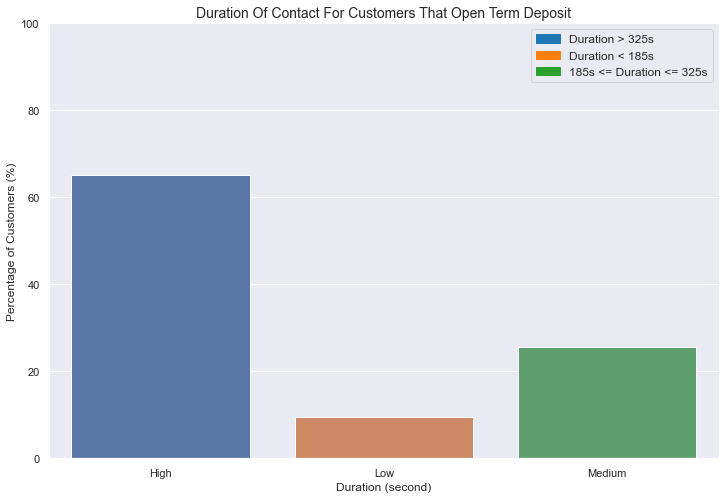

In [108]:
plt.figure(figsize=(12,8))
sns.barplot(x=visualization_duration['Duration Category'],
            y=visualization_duration['Ratio'])
plt.title('Duration Of Contact For Customers That Open Term Deposit',fontsize=14)
plt.xlabel('Duration (second)',fontsize=12)
plt.ylabel('Percentage of Customers (%)',fontsize=12)
plt.ylim(0,100)
colors = {'Duration > 325s':'tab:blue', 'Duration < 185s':'tab:orange', '185s <= Duration <= 325s':'tab:green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, loc= 'upper right' ,fontsize = 12)
plt.show()

* Terlihat bahwa sebagian besar nasabah yang memutuskan untuk membuka term deposit memiliki durasi panggilan yang tinggi. Namun, bukan berarti durasi panggilan yang tinggi mempengaruhi keputusan nasabah karena bisa saja nasabah sejak awal tertarik untuk membuka term deposit dan hanya ingin mengetahui lebih jauh tentang produk tersebut, sehingga durasi panggilan menjadi lebih tinggi. Karena bisa juga dilihat dari visualisasi ada nasabah yang memutuskan untuk membuka term deposit namun memiliki durasi call yang rendah. Jadi dibandingkan dengan memfokuskan untuk dapat menjelaskan produk deposito berjangka kepada customer dengan durasi yang tinggi sebaiknya pihak bank memberikan batasan bagi tim marketing untuk mengupayakan dapat menjelaskan produk kurang dari misalkan 5 menit. Sehingga cost dari biaya telepon tersebut dapat dialihkan kepada promosi deposito berjangka melalui media lain seperti iklan, dll.

**CONTACT**

In [109]:
visualization_contact = yes_prediction.groupby(['contact']).agg({'contact':'count'})
visualization_contact.columns = ['Number of Each Group']
visualization_contact.reset_index(inplace=True)

In [110]:
visualization_contact['Ratio'] = round((visualization_contact['Number of Each Group']/visualization_contact['Number of Each Group'].sum())*100,2)
visualization_contact

,contact,Number of Each Group,Ratio
0,0,2011,83.83
1,1,140,5.84
2,2,248,10.34


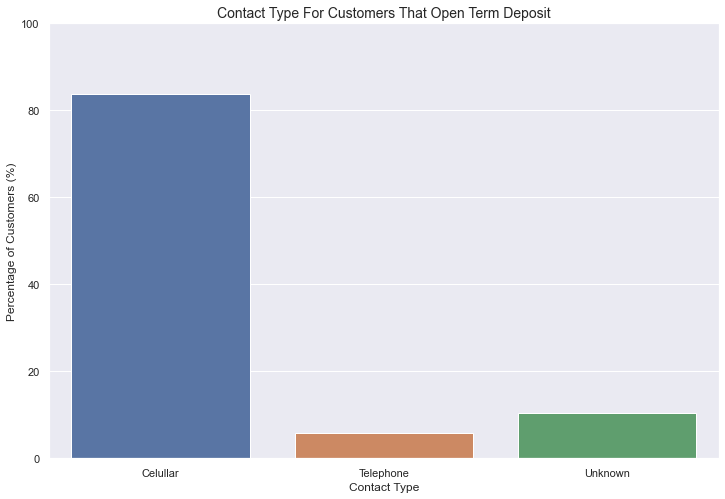

In [111]:
plt.figure(figsize=(12,8))
sns.barplot(x=visualization_contact['contact'],
            y=visualization_contact['Ratio'])
plt.title('Contact Type For Customers That Open Term Deposit',fontsize=14)
plt.xlabel('Contact Type',fontsize=12)
plt.xticks([0, 1, 2], ['Celullar', 'Telephone', 'Unknown'])
plt.ylabel('Percentage of Customers (%)',fontsize=12)
plt.ylim(0,100)
plt.show()

* Bisa dilihat melalui visualisasi diatas bahwa orang-orang yang memilih untuk membuka deposito berjangka paling banyak dihubungi melalui telepon celullar. Hal ini bisa terjadi karena di era sekarang ini orang-orang lebih banyak melakukan komunikasi melalui telepon celullar dibandingkan telepon biasa, dan hampir setiap orang pasti mempunyai telepon cellular. **Apabila customer mempunyai celullar phone dan telephone biasa pihak bank dapat memprioritaskan melakukan contact melalui telepon celullar dibandingkan dengan telephone biasa**. Selain itu pihak bank sebelum melakukan panggilan secara langsung ke nomor telepon celullar, bisa juga melakukan campaign dengan memanfaatkan fitur yang dimiliki telepon celullar yaitu bisa melalui email, push notification pada aplikasi m-banking sebagai tahapan awal dalam menawarkan deposito berjangka. Dengan demikian peluang customer yang mendaftar deposito berjangka akan meningkat.

## **CVR SIMULATION**

Asumsi Campagin : <br>

* Simulasi antara 1 orang Blind Marketing vs 1 orang with Machine Learning <br>
* Start Date - End Date = **1 November 2022 - 16 December 2022 (Waktu Produktif Kerja = 34 days)** <br>
* Ideal Call Duration for Marketing = 2 - 9 minutes, **use 5 minutes** (from avg) <br>
* Karyawan di bank start 9:00am - 17:00pm, Waktu bersih dalam 1 hari kerja (potong jam makan siang 1 jam) = **7 jam = 420 minutes** <br>
* 1 orang/days bisa call = 420 minutes/5minutes = **84 customers** <br>
Maka selama campaign 1 orang bisa call customers sebanyak 84 customers * 34 days = **2856 customers/day**

In [112]:
X_simulasi = X_test_new.copy()
X_simulasi['actual_result'] = y_test_new

In [113]:
X_blind_marketing = X_simulasi[:2856]
X_blind_marketing

,age,balance,housing,loan,contact,duration,campaign,job_blue-collar,marital_divorced,marital_married,poutcome_success,actual_result
1392,40,640,1,1,2,347,2,1,0,1,0,0
7518,44,378,1,0,2,203,2,0,0,1,0,0
12007,31,356,1,0,2,228,5,0,0,1,0,0
5536,36,655,1,0,2,153,4,1,0,1,0,0
29816,34,1921,1,0,0,61,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10796,54,6622,0,0,2,83,1,1,0,0,0,0
18748,54,235,0,1,0,28,5,0,0,1,0,0
35202,34,-131,1,0,0,132,1,1,1,0,0,0
32467,48,117,1,0,0,635,1,0,0,1,0,0


In [114]:
X_blind_marketing = X_blind_marketing[X_blind_marketing['actual_result']==1]
X_blind_marketing

,age,balance,housing,loan,contact,duration,campaign,job_blue-collar,marital_divorced,marital_married,poutcome_success,actual_result
43965,64,109,0,0,0,706,1,0,1,0,1,1
41933,31,6281,0,0,0,257,1,1,0,0,0,1
34965,49,99,1,0,0,687,2,0,0,1,0,1
43479,51,469,0,0,0,200,1,0,0,1,1,1
28098,51,394,0,0,1,968,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
24390,53,2228,0,0,0,890,1,0,1,0,0,1
35820,36,0,1,0,0,308,3,0,0,1,0,1
41193,62,0,1,0,0,158,1,0,1,0,0,1
42253,38,1767,1,0,0,893,7,0,0,1,0,1


In [115]:
X_machine_learning = X_test_new.copy()
X_machine_learning['prediction_result'] = y_pred
X_machine_learning['actual_result'] = y_test_new

In [116]:
X_ml_yes = X_machine_learning[X_machine_learning['prediction_result']==1]
X_machine_learning_results = X_ml_yes[X_ml_yes['actual_result']==1]
X_machine_learning_results

,age,balance,housing,loan,contact,duration,campaign,job_blue-collar,marital_divorced,marital_married,poutcome_success,prediction_result,actual_result
43965,64,109,0,0,0,706,1,0,1,0,1,1,1
41933,31,6281,0,0,0,257,1,1,0,0,0,1,1
34965,49,99,1,0,0,687,2,0,0,1,0,1,1
43479,51,469,0,0,0,200,1,0,0,1,1,1,1
28098,51,394,0,0,1,968,2,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10403,40,406,1,0,2,577,2,0,0,1,0,1,1
36087,41,-109,1,1,0,1038,1,0,0,0,0,1,1
42915,29,19,0,0,0,110,2,0,0,0,1,1,1
40942,43,451,0,0,0,289,2,0,0,0,0,1,1


Hasil Simulasi : <br>

* 1 Person with Blind Marketing can obtain 341 customers from 9043 customers data = **3.61% conversion rate**
* 1 Person with Machine Learning can obtain 912 customers from 9043 customers data = **9.72% conversion rate**

Jadi dengan machine learning kita dapat **meningkatkan conversion rate kurang lebih sebesar 6.11%**, goals yang ditetapkan terpenuhi yaitu meningkatkan minimal 5% conversion rate.

## **COST SIMULATION**

Asumsi Perhitungan Cost : <br>

* Call/minute = 0.20 Euro/minute <br>
* 1 Customers duration 5 minutes, cost for 1 customers = 1 Euro

In [117]:
X_marketing_cost = X_test_new.copy()
X_marketing_cost['actual_result'] = y_test_new
X_marketing_cost.index = np.arange(1, len(X_marketing_cost) + 1)
X_marketing_cost

,age,balance,housing,loan,contact,duration,campaign,job_blue-collar,marital_divorced,marital_married,poutcome_success,actual_result
1,40,640,1,1,2,347,2,1,0,1,0,0
2,44,378,1,0,2,203,2,0,0,1,0,0
3,31,356,1,0,2,228,5,0,0,1,0,0
4,36,655,1,0,2,153,4,1,0,1,0,0
5,34,1921,1,0,0,61,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9039,26,-333,0,1,2,692,1,1,0,0,0,0
9040,49,884,1,0,1,201,3,0,0,1,0,0
9041,32,964,1,0,0,370,2,0,0,1,0,0
9042,20,0,0,0,0,69,4,0,0,0,0,0


In [118]:
count = 0
lst_count = []
for i in range(len(X_marketing_cost)):
    if X_marketing_cost.actual_result.iloc[i] == 1:
        count+=1
        lst_count.append(count)
    else:
        lst_count.append('-')
X_marketing_cost['count'] = lst_count

In [119]:
X_marketing_cost = X_marketing_cost[X_marketing_cost['count']!='-']
X_marketing_cost[X_marketing_cost['count']==879]

,age,balance,housing,loan,contact,duration,campaign,job_blue-collar,marital_divorced,marital_married,poutcome_success,actual_result,count
7610,33,1699,0,0,0,600,1,0,0,1,0,1,879


Marketing harus menelpon sampai 7610 customers untuk mendapatkan 879 customers yang tertarik membuka deposito

In [120]:
X_ml_cost = X_test_new.copy()
X_ml_cost['prediction_result'] = y_pred
X_ml_cost['actual_result'] = y_test_new

In [121]:
X_ml_cost = X_ml_cost[X_ml_cost['prediction_result']==1]
X_ml_cost[X_ml_cost['actual_result']==1]
X_ml_cost

,age,balance,housing,loan,contact,duration,campaign,job_blue-collar,marital_divorced,marital_married,poutcome_success,prediction_result,actual_result
18275,41,1138,0,0,0,283,18,0,0,0,0,1,0
43965,64,109,0,0,0,706,1,0,1,0,1,1,1
35351,42,2348,1,0,0,448,2,0,0,0,0,1,0
3430,35,1215,1,0,2,597,1,1,0,0,0,1,0
41933,31,6281,0,0,0,257,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40942,43,451,0,0,0,289,2,0,0,0,0,1,1
31427,57,3858,0,0,0,558,1,0,0,1,0,1,0
44253,43,839,0,0,0,942,1,0,0,1,0,1,1
12636,26,-333,0,1,2,692,1,1,0,0,0,1,0


Marketing with Machine Learning harus menelpon sampai 2399 customers untuk mendapatkan 879 customers yang tertarik membuka deposito

Hasil Simulasi Cost : <br>
To obtain 879 customers
* 1 Person with Blind Marketing cost 7610 Euro <br>
* 1 Person with Machine Learning cost 2399 Euro <br>

Jadi dengan machine learning kita dapat **mengurangi cost sebesar 68.47%**, jadi meskipun lebih mengutamakan recall daripada precision tetapi ketika menggunakan model XGBoost maka cost juga akan berkurang sehingga model ini dapat diterapkan pada kasus-kasus real.